# Quick Start

This quick start tutorial will demonstrate the basic usage of DNAMite. For more detailed usage see the User Guide.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Regression

We'll start by importing some packages and reading in the California Housing dataset, a standard regression dataset.

In [2]:
# Import california housing dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

To fit a DNAMite model to this data, we use DNAMiteRegressor. The only required input parameter is the number of features we'd like our model to have. We also input a device so that the model trains on GPU. The model will fit a neural network for each feature as well as all pairwise interactions.

In [3]:
from dnamite.models import DNAMiteRegressor

model = DNAMiteRegressor(
    n_features=X_train.shape[1],
    device=device,
)
model.fit(X_train, y_train)

SPlIT 0
TRAINING MAINS


Early stopping at 88 epochs: Test loss has not improved for 5 consecutive epochs.
Didn't find selected pair indices. Selecting all pairs.
TRAINING PAIRS


Early stopping at 97 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING MAINS


TRAINING PAIRS


SPlIT 2
TRAINING MAINS


Early stopping at 91 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 97 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING MAINS


Early stopping at 85 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 95 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING MAINS


Early stopping at 63 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 81 epochs: Test loss has not improved for 5 consecutive epochs.


Let's first check that our model has reasonable predictive accuracy.

In [22]:
preds = model.predict(X_test)
print(f"RMSE: {np.sqrt(np.mean((preds - y_test)**2))}")

RMSE: 0.49536391455150003


We can now start interpreting our model. First we can look at the top feature importances from the model.

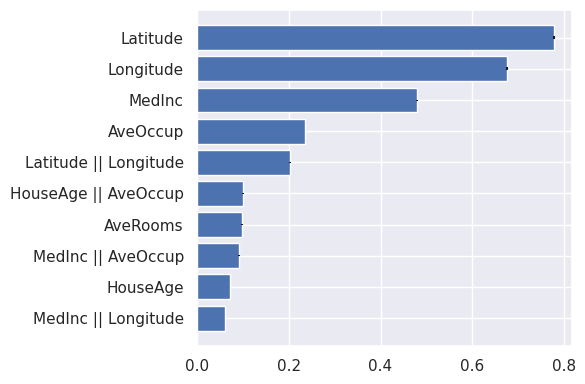

In [9]:
model.plot_feature_importances(k=10)

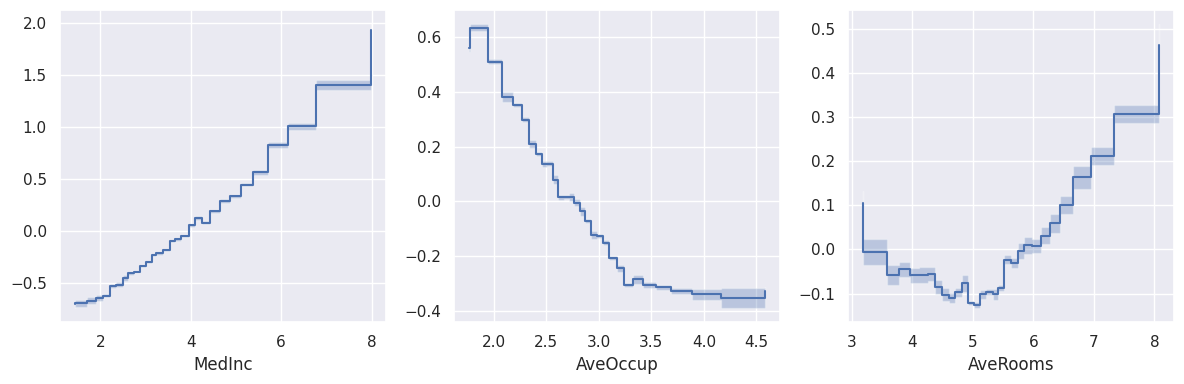

In [21]:
model.plot_shape_function(["MedInc", "AveOccup", "AveRooms"])

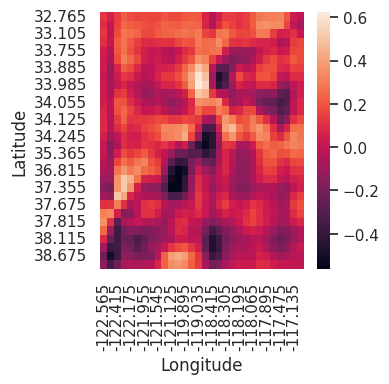

In [14]:
model.plot_pair_shape_function("Latitude", "Longitude")

## Survival Analysis

Now we'll switch gears and train a DNAMite model for survival analysis. Briefly, survival analysis involves predicting the probability that a time-to-event variable $T$ happens before $t$ for all times $t > 0$. See the User Guide for more details on survival analysis. We'll use the flchain dataset from scikit-survival.

In [77]:
from sksurv.datasets import load_flchain
X, y = load_flchain()

# Change y dtypes and names
y.dtype = np.dtype([('event', '?'), ('time', '<f8')])

# # Impute chapter with new category
X["chapter"] = X["chapter"].astype("category")
X["chapter"] = X["chapter"].cat.add_categories("Unknown")
X["chapter"] = X["chapter"].fillna("Unknown")

# Clip Training data to avoid overflow errors
X["creatinine"] = X["creatinine"].clip(-5, 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [78]:
X_train

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex
5471,56.0,Unknown,0.9,5,1.140,1.450,no,1996,F
2512,65.0,Unknown,1.2,2,0.828,1.160,no,1997,M
4242,62.0,Unknown,1.1,9,1.460,2.470,no,2000,F
810,79.0,Infectious,1.2,9,2.070,1.900,no,1997,M
1483,70.0,Unknown,NaN,5,1.130,1.530,no,2002,F
...,...,...,...,...,...,...,...,...,...
3441,67.0,Unknown,1.0,1,0.316,0.972,no,1996,F
1344,76.0,Circulatory,1.1,5,1.500,1.300,no,2001,F
4623,62.0,Unknown,1.1,8,1.840,1.920,no,1996,F
7293,52.0,Unknown,0.9,2,0.877,0.946,no,1996,F


Fitting a DNAMite model for survival analysis is very similar to fitting a DNAMite regression model. 

In [85]:
from dnamite.models import DNAMiteSurvival

model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    device=device,
)
model.fit(X_train, y_train)

SPlIT 0
TRAINING MAINS


Early stopping at 58 epochs: Test loss has not improved for 5 consecutive epochs.
Didn't find selected pair indices. Selecting all pairs.
TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING MAINS


TRAINING PAIRS


Early stopping at 89 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
TRAINING MAINS


Early stopping at 57 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 74 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING MAINS


TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING MAINS


Early stopping at 87 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.


In [86]:
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored

def get_auc(surv_preds, y_train, y_test, eval_times):
    test_times = np.linspace(
        max(y_train["time"].min(), y_test[y_test["event"] > 0]["time"].min()) + 1e-4,
        min(y_train["time"].max(), y_test[y_test["event"] > 0]["time"].max()) - 1e-4,
        1000
    )
    
    surv_preds = surv_preds[
        :, 
        np.clip(
            np.searchsorted(eval_times.cpu().numpy(), test_times),
            0, surv_preds.shape[1]-1
        )
    ]
    risk_preds = -1 * np.log(np.clip(surv_preds, 1e-5, 10 - 1e-5))
    # Get time-dependent AUC
    _, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_preds, test_times)
    
    return mean_auc

In [87]:
# After fixing categorical features
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

test_preds = model.predict(X_test)
surv_preds = 1 - sigmoid(test_preds)
auc = get_auc(surv_preds, y_train, y_test, model.eval_times)
auc

0.9493571365812357

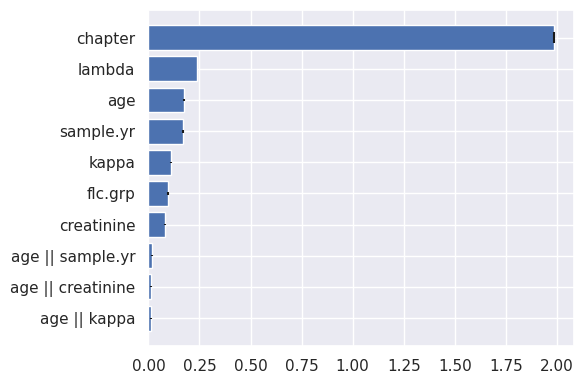

In [88]:
model.plot_feature_importances(k=10, eval_time=365*5)

In [48]:
X["chapter"].value_counts()

chapter
Unknown                 5705
Circulatory              745
Neoplasms                567
Respiratory              245
Mental                   144
Nervous                  130
Digestive                 66
External Causes           66
Endocrine                 48
Genitourinary             42
Ill Defined               38
Infectious                32
Injury and Poisoning      21
Musculoskeletal           14
Skin                       4
Blood                      4
Congenital                 3
Name: count, dtype: int64

In [55]:
ord_encoder = model.preprocessor.transformers_[0][1]
feat_index = np.where(ord_encoder.feature_names_in_ == "chapter")[0][0]
pd.DataFrame({
    "input": ord_encoder.categories_[feat_index],
    "output": np.arange(len(ord_encoder.categories_[feat_index]))
})

,input,output
0,Blood,0
1,Circulatory,1
2,Congenital,2
3,Digestive,3
4,Endocrine,4
5,External Causes,5
6,Genitourinary,6
7,Ill Defined,7
8,Infectious,8
9,Injury and Poisoning,9


In [69]:
col_index = model.models[0].feature_names_in_.get_loc("chapter")
model.models[0].feature_bins[col_index]

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  9.5, 10.5, 11.5,
       12.5, 13.5, 14.5, 15.5])

In [76]:
print(model.preprocess_data(X)["chapter"])

from dnamite.utils import discretize
discretize(model.preprocess_data(X)["chapter"], max_bins=32)

0        1.0
1       12.0
2        1.0
3        1.0
4        1.0
        ... 
7869    16.0
7870    16.0
7871    16.0
7872    16.0
7873    16.0
Name: chapter, Length: 7874, dtype: float64


(array([ 2, 11,  2, ..., 15, 15, 15]),
 array([ 0.5,  1.5,  3.5,  4.5,  5.5,  6.5,  7.5,  9.5, 10.5, 11.5, 12.5,
        13.5, 14.5, 15.5]))

In [60]:
from dnamite.utils import discretize
discretize(X["chapter"], max_bins=10)

ValueError: Cannot cast object dtype to float64

In [92]:
model.get_shape_function("chapter", eval_time=365*5, is_cat_col=True).iloc[:30]

FEAT BIN VALUE FOR MODEL 0 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 1 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 2 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 3 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury

,feature,bin,score,count,split
0,chapter,NA,1.683809,0.0,0
1,chapter,Blood,2.417068,1.0,0
2,chapter,Circulatory,3.274346,478.0,0
3,chapter,Congenital,3.770434,1.0,0
4,chapter,Digestive,3.513638,41.0,0
5,chapter,Endocrine,3.350843,31.0,0
6,chapter,External Causes,3.349609,43.0,0
7,chapter,Genitourinary,2.771673,27.0,0
8,chapter,Ill Defined,2.378489,24.0,0
9,chapter,Infectious,2.894842,19.0,0


FEAT BIN VALUE FOR MODEL 0 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 1 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 2 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms', 'Nervous', 'Respiratory', 'Skin', 'Unknown']
FEAT BIN VALUE FOR MODEL 3 : ['NA', 'Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Injury

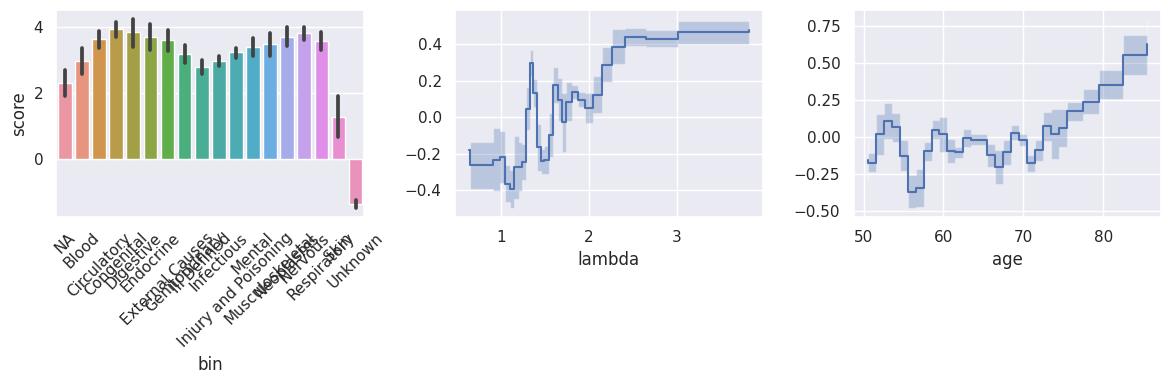

In [93]:
model.plot_shape_function(["chapter", "lambda", "age"], eval_time=365*5, is_cat_cols=[True, False, False])